In [1]:
import random
import multiprocessing

import h5py
import tqdm

import numpy as np
import sys, os

sys.path.append(os.path.join('..', 'lib'))
import lif_utils
import env_guard
from nonneg_common import *

import sklearn.linear_model

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

In [18]:
def forkrng(rng=np.random):
    return np.random.RandomState(rng.randint((1 << 31)))

def sparsity(*matrices, th=1e-6):
    N_total = 0
    N_zero = 0
    for M in matrices:
        N_total += M.size
        N_zero += np.sum(np.abs(M) < th)
    return N_zero / N_total

In [19]:
def single_experiment(N_pre=101,
                      N_post=101,
                      N_smpls=101,
                      N_test=1001,
                      f=lambda x: x,
                      p_exc=0.5,
                      do_dale=True,
                      do_decode_bias=True,
                      sigma=0.1,
                      rng=np.random):
    gains_pre, biases_pre, encoders_pre = mk_ensemble(N_pre, rng=forkrng(rng))
    gains_post, biases_post, encoders_post = mk_ensemble(N_post,
                                                         rng=forkrng(rng))

    # Sample the source space
    xs = np.linspace(-1, 1, N_smpls).reshape(-1, 1)

    # Compute the target values
    ys = f(xs)
    ys_rms = np.sqrt(np.mean(np.square(ys)))

    # Determine the pre-activities
    Js_pre = gains_pre[None, :] * (xs @ encoders_pre.T) + biases_pre[None, :]
    As_pre = lif_utils.lif_rate(Js_pre)

    # Determine the post-population decoder
    Js_post = gains_post[None, :] * (xs @ encoders_post.T) + biases_post[
        None, :]
    As_post = lif_utils.lif_rate(Js_post)
    A = (As_post.T @ As_post +
         N_smpls * np.square(sigma * np.max(As_post)) * np.eye(N_post))
    Y = As_post.T @ xs[:, 0]
    D_post = np.linalg.solve(A, Y)

    # Determine the target currents
    Js_post = gains_post[None, :] * (ys @ encoders_post.T) + biases_post[
        None, :]
    if do_decode_bias:
        Js_tar = Js_post
    else:
        Js_tar = Js_post - biases_post[None, :]

    # Compute the weight matrix
    W_exc, W_inh, idcs_exc, idcs_inh = decode_currents(As_pre,
                        Js_tar,
                        p_exc=p_exc,
                        do_dale=do_dale,
                        sigma=sigma,
                        split=True,
                        rng=forkrng(rng))

    # Compute a SVD of the matrix
    U_exc, S_exc, V_exc = np.linalg.svd(W_exc)
    U_inh, S_inh, V_inh = np.linalg.svd(W_inh)
    N_exc = len(idcs_exc)
    N_inh = len(idcs_inh)

    # Generate the test samples
    xs = np.linspace(-1, 1, N_test).reshape(-1, 1)
    ys = f(xs)
    ys_rms = np.sqrt(np.mean(np.square(ys)))
    Js_pre = gains_pre[None, :] * (xs @ encoders_pre.T) + biases_pre[None, :]
    As_pre = lif_utils.lif_rate(Js_pre)

    max_d = min(N_pre, N_post)
    errs = np.zeros(max_d)
    for d in range(max_d):
        d_exc = min(N_exc, d)
        d_inh = min(N_inh, d)
        W_exc_rec = U_exc[:, :d_exc] @ np.diag(S_exc[:d_exc]) @ V_exc[:d_exc]
        W_inh_rec = U_inh[:, :d_inh] @ np.diag(S_inh[:d_inh]) @ V_inh[:d_inh]

        Js_exc_dec = np.clip(As_pre[:, idcs_exc] @ W_exc_rec.T, 0, None)
        Js_inh_dec = np.clip(As_pre[:, idcs_inh] @ W_inh_rec.T, 0, None)
        Js_dec = Js_exc_dec - Js_inh_dec                 

        As_dec = lif_utils.lif_rate(Js_dec + (0 if do_decode_bias else biases_post[None, :]))
        errs[d] = np.sqrt(np.mean(np.square(As_dec @ D_post.T - ys[:, 0]))) / ys_rms

    return errs

(-1.0, 6.0)

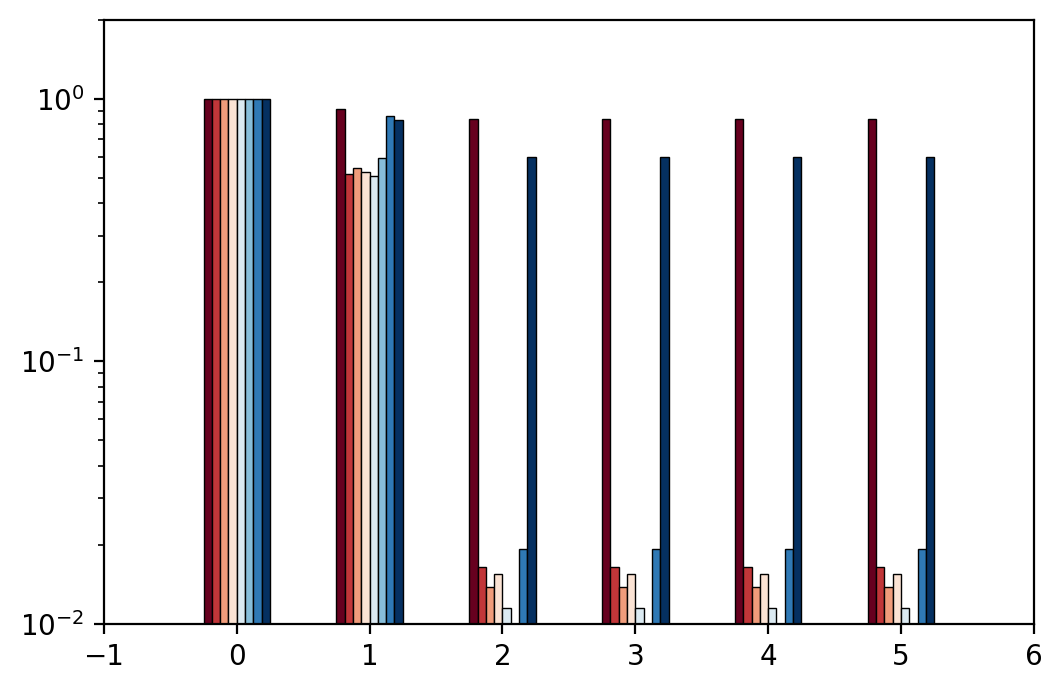

In [20]:
np.random.seed(4921982)

fig, ax = plt.subplots()
N = 8
width = 0.5
for j, p_exc in enumerate(np.linspace(0, 1, N)):
    #errs = single_experiment(p_exc=p_exc, do_decode_bias=True, f=lambda x: 2.0 * np.square(x) - 1.0)
    errs = single_experiment(p_exc=p_exc, do_decode_bias=False)
    for i in range(6):
        x = i + j * (width / N) - 0.5 * width + 0.5 * width / N
        ax.bar(x, errs[i], width=width/N, color=mpl.cm.get_cmap('RdBu')(p_exc), edgecolor='k', linewidth=0.5)
ax.set_yscale('log')
ax.set_ylim(1e-2, 2)
ax.set_xlim(-1, 6)

In [31]:
def single_experiment_sparsity(mode="nnls",
                               N_pre=101,
                               N_post=102,
                               N_smpls=101,
                               N_test=10001,
                               f=lambda x: x,
                               p_exc=0.5,
                               sigma=0.1,
                               reg_l1=0.0,
                               p_dropout=0,
                               do_decode_bias=False,
                               rng=np.random):

    assert mode in {"nnls", "lasso", "dropout"}

    gains_pre, biases_pre, encoders_pre = mk_ensemble(N_pre, rng=forkrng(rng))
    gains_post, biases_post, encoders_post = mk_ensemble(N_post,
                                                         rng=forkrng(rng))

    # Sample the source space
    xs = np.linspace(-1, 1, N_smpls).reshape(-1, 1)

    # Compute the target values
    ys = f(xs)
    ys_rms = np.sqrt(np.mean(np.square(ys)))

    # Determine the pre-activities
    Js_pre = gains_pre[None, :] * (xs @ encoders_pre.T) + biases_pre[None, :]
    As_pre = lif_utils.lif_rate(Js_pre)

    # Determine the post-population decoder
    Js_post = gains_post[None, :] * (xs @ encoders_post.T) + biases_post[
        None, :]
    As_post = lif_utils.lif_rate(Js_post)
    A = (As_post.T @ As_post +
         N_smpls * np.square(sigma * np.max(As_post)) * np.eye(N_post))
    Y = As_post.T @ xs[:, 0]
    D_post = np.linalg.solve(A, Y)

    # Determine the target currents
    Js_post = gains_post[None, :] * (ys @ encoders_post.T) + biases_post[
        None, :]
    if do_decode_bias:
        Js_tar = Js_post
    else:
        Js_tar = Js_post - biases_post[None, :]

    # Compute the weight matrix
    W = np.zeros((N_post, N_pre))
    if mode == 'nnls':
        # Use our NNLS method
        W_exc, W_inh, idcs_exc, idcs_inh = decode_currents(As_pre,
                                                           Js_tar,
                                                           p_exc=p_exc,
                                                           sigma=sigma,
                                                           rng=forkrng(rng),
                                                           split=True)

        # Compute the sparsity of the excitatory and inhibitory matrix
        s = sparsity(W_exc, W_inh)

        # Compute the actual weight matrix for the error computation
        W[:, idcs_exc] += W_exc
        W[:, idcs_inh] -= W_inh
    elif mode == 'lasso':
        # Compute the L2-regularised problem
        ATA = As_pre.T @ As_pre + np.square(
            sigma * np.max(As_pre)) * N_smpls * np.eye(N_pre)
        Y = As_pre.T @ Js_tar

        # Setup a Lasso classifier
        clf = sklearn.linear_model.Lasso(alpha=np.square(reg_l1),
                                         max_iter=10000,
                                         tol=1e-4,
                                         fit_intercept=False,
                                         warm_start=True)
        for i in range(N_post):
            # Initialize the solver with the L2 solution. For some reason
            # the solver will have trouble to converge to the true optimum
            # otherwise
            setattr(clf, 'coef_', np.linalg.solve(ATA, Y[:, i]))

            # Perform the regression
            clf.fit(ATA, Y[:, i])

            # Store the computed coefficients!
            W[i] = clf.coef_

        s = sparsity(W)
    elif mode == 'dropout':
        # Compute the L2-regularised problem
        ATA = As_pre.T @ As_pre + np.square(
            sigma * np.max(As_pre)) * N_smpls * np.eye(N_pre)
        Y = As_pre.T @ Js_tar

        # Compute the solution
        for i in range(N_post):
            W[i] = np.linalg.solve(ATA, Y[:, i])

        # Determine which neurons are below the threshold
        mask = np.abs(W) >= np.percentile(np.abs(W), p_dropout)

        # Re-compute the solution with the mask applied
        W = np.zeros((N_post, N_pre))
        for i in range(N_post):
            As_pre2 = As_pre[:, mask[i]]
            N_pre2 = int(np.sum(mask[i]))
            ATA = As_pre2.T @ As_pre2 + np.square(
                sigma * np.max(As_pre)) * N_smpls * np.eye(N_pre2)
            Y = As_pre2.T @ Js_tar[:, i]
            W[i, mask[i]] = np.linalg.solve(ATA, Y)

        s = sparsity(W)

    # Generate the test data
    xs = np.linspace(-1, 1, N_test).reshape(-1, 1)
    ys = f(xs)
    ys_rms = np.sqrt(np.mean(np.square(ys)))

    Js_pre = gains_pre[None, :] * (xs @ encoders_pre.T) + biases_pre[None, :]
    As_pre = lif_utils.lif_rate(Js_pre)

    Js_dec = As_pre @ W.T
    As_dec = lif_utils.lif_rate(
        Js_dec + (0 if do_decode_bias else biases_post[None, :]))

    e = np.sqrt(np.mean(np.square(As_dec @ D_post.T - ys[:, 0]))) / ys_rms

    return s, e

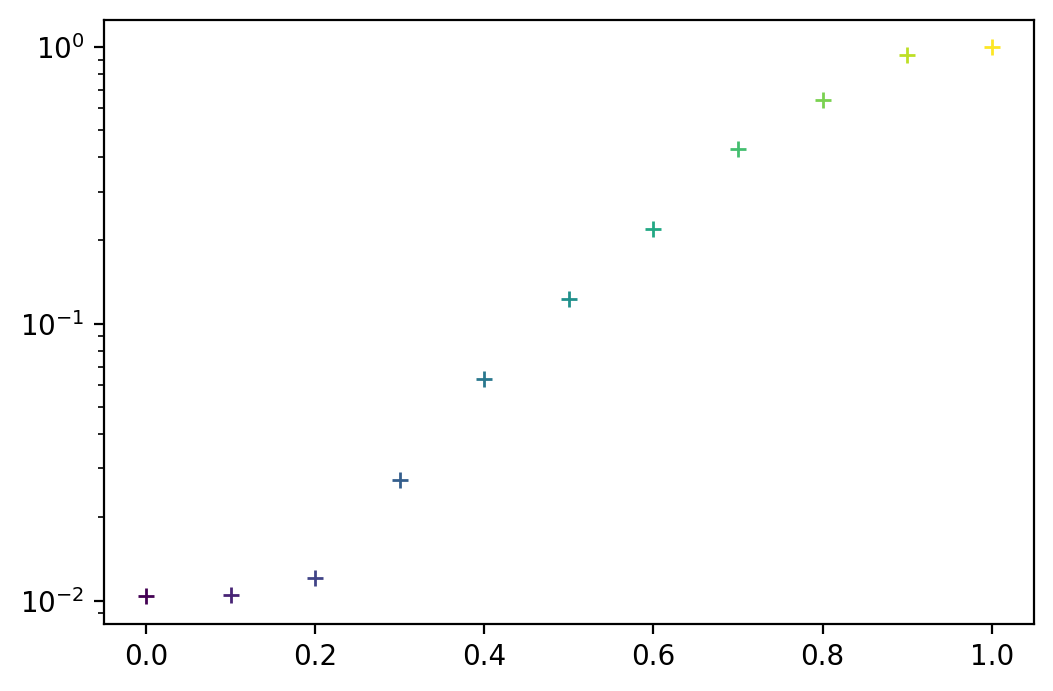

In [32]:
fig, ax = plt.subplots()
N = 11
#for i, p_exc in enumerate(np.linspace(0.0, 1.0, N)):
#for i, reg_l1 in enumerate(np.logspace(1, 3, N)):
for i, p_dropout in enumerate(np.linspace(0, 100, N)):
    for j in range(1):
        s, e = single_experiment_sparsity(mode='dropout', p_dropout=p_dropout, rng=np.random.RandomState(j), do_decode_bias=False)
        ax.plot(s, e, '+', color=mpl.cm.get_cmap('viridis')(i / (N - 1)))
ax.set_yscale('log')